## Direct Logit Attribution

https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=3XtmNaDFO0eu

In [1]:
import torch, transformer_lens, itertools
from functools import partial
from measureLM import visualizing, decoding, patching, scoring

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

def plot_heatmap(array, title='', cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=hook_names, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel('layers', fontsize=labelsize)
    plt.show()

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [84]:
def early_decoding(activs, model, hook_name="mlp_out", layer=-1):
    h = activs[hook_name, layer]
    scores = model.unembed(model.ln_final(h))[:, -1, :].squeeze()
    return scores
   

def get_token_rank(scores, model, token):
    assert "spacing" in dir(model.cfg), "need to set e.g. model.cfg.spacing = Ġ"
    token = model.cfg.spacing + token
    token_id = model.tokenizer.convert_tokens_to_ids(token)
    token_ranks = torch.argsort(scores, descending=True)

    token_scores = scores[token_ranks]
    token_rank = torch.where(token_ranks == token_id)[0].item()
    token_score = token_scores[token_rank]
    token_rank = round(1 / (token_rank + 1), 4)  # round(1-(token_rank / len(scores)), 4)
    return token_rank, token_score


def topK_scores(scores, model, topk=5):
    pred_scores, pred_tokens = [], []
    topK_preds = torch.topk(scores, k=topk)

    scores = topK_preds.values.tolist()
    indices = topK_preds.indices.tolist()
    # for scores, indices in zip(topK_preds.values.tolist(), topK_preds.indices.tolist()):
    scores = list(map(lambda score: round(score, 2), scores))
    pred_scores.append(scores)
    tokens = list(map(lambda idx: model.tokenizer.convert_ids_to_tokens(idx), indices))
    pred_tokens.append(tokens)
    return pred_tokens, pred_scores

## Direct Logit Attribution

In [132]:
def get_logit_diff_dirs(model, scales):
    if isinstance(scales, str):
        scales = [scales]
    logit_diff_dir = torch.empty(len(scales), model.cfg.d_model)
    for i, scale in enumerate(scales):
        scale_ids = torch.tensor([model.tokenizer.convert_tokens_to_ids(model.cfg.spacing + token) for token in scale])
        #unembed_vecs = model.tokens_to_residual_directions(scale_ids) # model.unembed.W_U
        unembed_vecs = torch.index_select(model.unembed.W_U, dim=-1, index=scale_ids)
        logit_diff_dir[i,:] = unembed_vecs[...,0] - unembed_vecs[...,1]
    return logit_diff_dir
    
logit_diff_dir = get_logit_diff_dirs(model, scales=[["love", "loved"]])
logit_diff_dir.shape

torch.Size([1, 1024])

In [133]:
def residual_to_logit_diff(activs, logit_diff_dir, hook_name="resid_pre", layer=-1):
    h = activs[hook_name, layer]
    h = model.ln_final(h)[:, -1, :]
    #h = h[:, -1, :]
    #h = activs.apply_ln_to_stack(h, layer = -1, pos_slice=-1)
    logit_attr = torch.einsum('...nd,...sd->s', h, logit_diff_dir)
    return logit_attr

prompt = ["Today I kiss. Yesterday, I kissed. Today I love. Yesterday, I"]
logits, activs = model.run_with_cache(prompt)
logit_attr = residual_to_logit_diff(activs, logit_diff_dir)
logit_attr

tensor([-2.6474], grad_fn=<ViewBackward0>)

0 resid_pre [['Ġunden', 'Ġenthusi', 'Ġhelicop', 'Ġobser', 'Ġtrave']] [[56.41, 54.13, 53.81, 52.81, 50.26]]
0 resid_mid [['Ġunden', 'Ġobser', 'Ġtrave', 'Ġhelicop', 'Ġenthusi']] [[45.68, 45.33, 45.05, 45.03, 43.09]]
1 resid_pre [['Ġam', "'m", 'ĠAm', 'Ġ(', 'Ġ']] [[10.6, 10.19, 8.53, 8.39, 8.16]]
1 resid_mid [['Ġam', "'m", 'ĠAm', "'ll", 'Ġwill']] [[11.43, 11.37, 9.58, 9.34, 8.91]]
2 resid_pre [['Ġam', "'m", 'ĠAm', "'ll", 'Ġwas']] [[11.49, 11.39, 9.72, 9.68, 9.0]]
2 resid_mid [['Ġam', "'m", "'ll", 'ĠAm', 'Ġwill']] [[11.7, 11.43, 9.95, 9.7, 9.66]]
3 resid_pre [['Ġam', "'m", "'ll", 'Ġwas', 'ĠAm']] [[11.82, 11.65, 9.84, 9.74, 9.6]]
3 resid_mid [['Ġam', "'m", "'ll", 'Ġwill', 'Ġwas']] [[11.99, 11.9, 10.56, 10.37, 10.31]]
4 resid_pre [["'m", 'Ġam', "'ll", 'Ġwas', 'Ġwill']] [[12.83, 12.36, 11.51, 11.17, 10.82]]
4 resid_mid [["'m", 'Ġam', "'ll", 'Ġwas', 'Ġwill']] [[13.15, 12.36, 11.9, 11.7, 11.28]]
5 resid_pre [["'m", 'Ġam', "'ll", 'Ġwas', "'ve"]] [[14.0, 12.88, 12.47, 11.9, 11.71]]
5 resid_mid [["

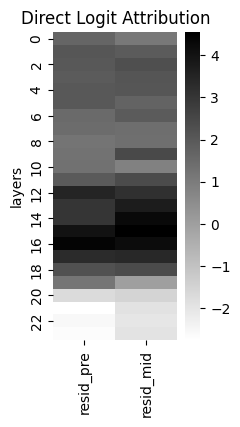

In [135]:
n_layers = model.cfg.n_layers
hook_names = ["resid_pre", "resid_mid"]
logit_attr = torch.zeros(n_layers, len(hook_names)) ## times hook_names

for layer in range(n_layers):
    for hook_i, hook_name in enumerate(hook_names): 
        logit_attr[layer, hook_i] = residual_to_logit_diff(activs, logit_diff_dir, hook_name, layer)
        
        scores = early_decoding(activs, model, hook_name=hook_name, layer=layer)
        #token_rank, token_score = get_token_rank(scores, model, "positive")
        pred_tokens, pred_scores = topK_scores(scores, model)
        print(layer, hook_name, pred_tokens, pred_scores)
                
plot_heatmap(logit_attr.detach().numpy(), title='Direct Logit Attribution', cmap="binary")